In [1]:
# Get electron microscopy dataset (https://www.epfl.ch/labs/cvlab/data/data-em/)
# !wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/volumedata.tif

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
! pip install -q kaggle

#from google.colab import files
# files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d andrewmvd/cancer-instance-segmentation-and-classification-2

 97% 673M/697M [00:10<00:00, 112MB/s]
100% 697M/697M [00:10<00:00, 71.3MB/s]


In [4]:
import zipfile

# Unzip the downloaded file
def unzip_data(zip_file_name):
  zip_ref = zipfile.ZipFile(zip_file_name, "r")
  zip_ref.extractall()
  zip_ref.close()

In [5]:
unzip_data('/content/cancer-instance-segmentation-and-classification-2.zip')

In [6]:
IMGS_PATH = '/content/Images/images.npy'
MASKS_PATH = '/content/Masks/masks.npy'

In [7]:
img_array = np.load(IMGS_PATH, mmap_mode='r')
mask_array = np.load(MASKS_PATH, mmap_mode='r')

In [8]:
print("Number of images: ", len(img_array))
print("Number of masks: ", len(mask_array))

Number of images:  2523
Number of masks:  2523


In [9]:
from sklearn.model_selection import train_test_split

# Use only first 600 images due to memory overflow
X_train, X_test, y_train, y_test = train_test_split(img_array[:600], mask_array[:600], test_size = 0.10, random_state = 0)

y_train = y_train[:,:,:,:3]  # Mask array shape (60, 256, 256, 6), convert it to the (60, 256, 256, 3)
y_test = y_test[:,:,:,:3]


print("X_train.shape: ", X_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (540, 256, 256, 3)
X_test.shape:  (60, 256, 256, 3)
y_train.shape:  (540, 256, 256, 3)
y_test.shape:  (60, 256, 256, 3)


In [10]:
print(f'X_train min: {np.min(X_train)}, X_train max: {np.max(X_train)}, X_test min: {np.min(X_test)}, X_test max: {np.max(X_test)}')
print(f'y_train min: {np.min(y_train)}, y_train max: {np.max(y_train)}, y_test min: {np.min(y_test)}, y_test max: {np.max(y_test)}')

X_train min: 0.0, X_train max: 255.0, X_test min: 0.0, X_test max: 255.0
y_train min: 0.0, y_train max: 744.0, y_test min: 0.0, y_test max: 378.0


We need to normalize/scale Mask images into [0,1]

In [11]:
normalize = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

y_train = normalize(y_train)
y_test = normalize(y_test)

print(f'y_train min: {np.min(y_train)}, y_train max: {np.max(y_train)}, y_test min: {np.min(y_test)}, y_test max: {np.max(y_test)}')

y_train min: 0.0, y_train max: 1.0, y_test min: 0.0, y_test max: 1.0


Normalize train and test images

In [12]:
X_train = normalize(X_train)
X_test = normalize(X_test)

print(f'X_train min: {np.min(X_train)}, X_train max: {np.max(X_train)}, X_test min: {np.min(X_test)}, X_test max: {np.max(X_test)}')

X_train min: 0.0, X_train max: 1.0, X_test min: 0.0, X_test max: 1.0


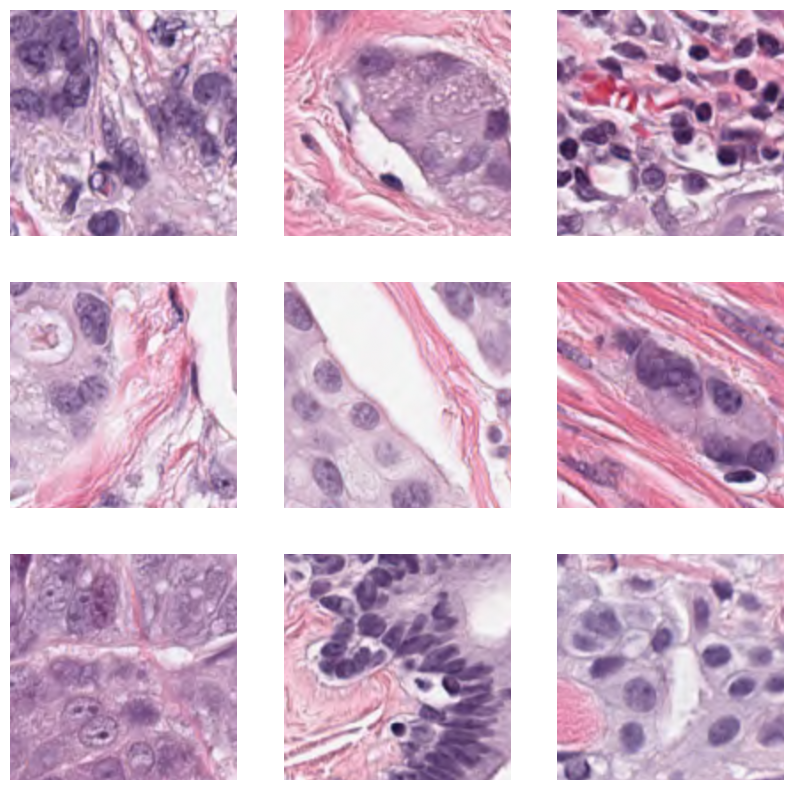

In [13]:
plt.figure(figsize=(10, 10))

for ix, images in enumerate(X_train[:9]):
    ax = plt.subplot(3, 3, ix + 1)
    plt.imshow(images)
    plt.axis("off")

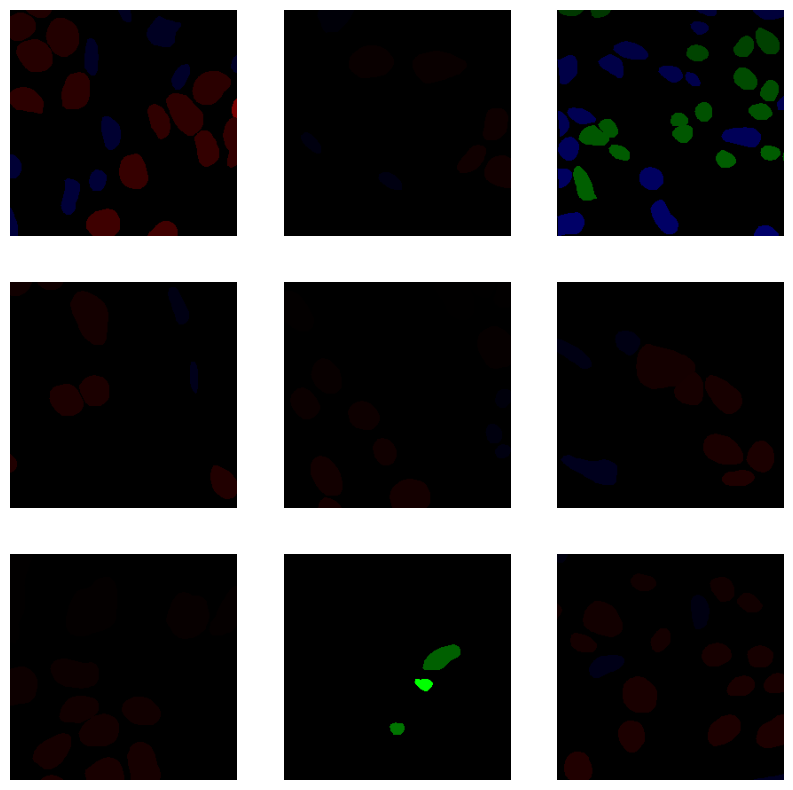

In [14]:
plt.figure(figsize=(10, 10))

for ix, images in enumerate(y_train[:9]):
    ax = plt.subplot(3, 3, ix + 1)
    plt.imshow(images)
    plt.axis("off")

Convert RGB mask images to binary mask images

In [15]:
def rgb_to_gray(images):
  return np.dot(images[..., :3], [0.299, 0.587, 0.114])

In [16]:
def convert_rgb_to_binary_mask(images):
  images = tf.image.rgb_to_grayscale(images).numpy()  # or use rgb_to_gray(images)
  images[images > 0.0] = 1.0
  return images

In [17]:
y_train = convert_rgb_to_binary_mask(y_train)
y_test = convert_rgb_to_binary_mask(y_test)

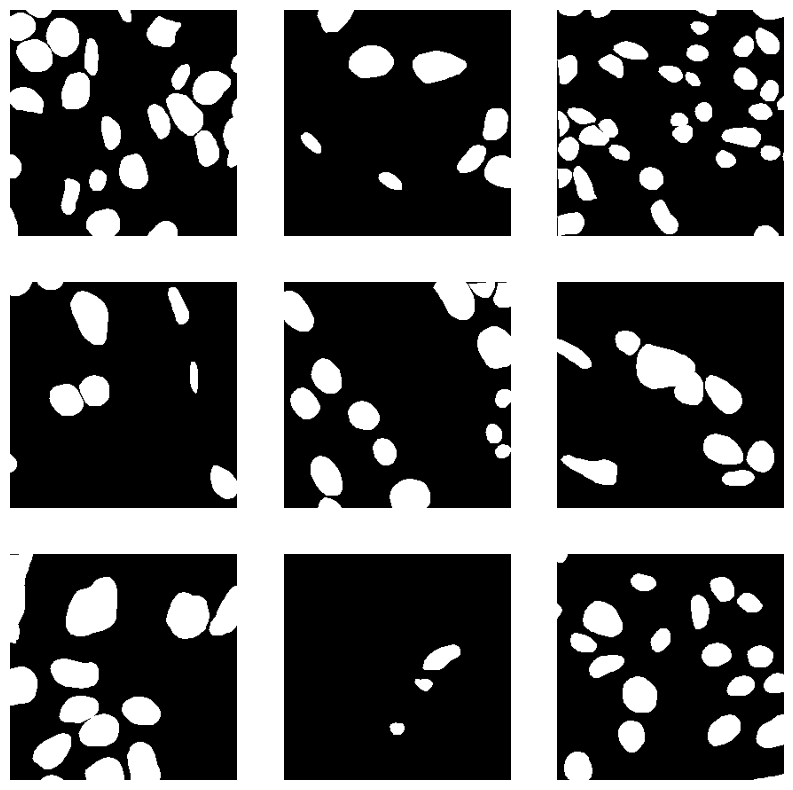

In [18]:
plt.figure(figsize=(10, 10))

for ix, images in enumerate(y_train[:9]):
    ax = plt.subplot(3, 3, ix + 1)
    plt.imshow(images, cmap='gray')
    plt.axis("off")

In [19]:
# Sample attention block
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import backend as K

def attention_block(x, gating, inter_shape):
  shape_x = K.int_shape(x)  # x
  shape_g = K.int_shape(gating)  # g

  # Getting x to the same shape as gating signal (128 to 64)
  theta_x = layers.Conv2D(inter_shape, (2,2), strides=(2,2), padding='same')(x)
  shape_theta_x = K.int_shape(theta_x)

  # Getting the gating signal to the same number of filters as the inter_shape
  phi_g = layers.Conv2D(inter_shape, (1,1), padding='same')(gating)
  upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                      strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                      padding='same')(phi_g)  # 16

  concat_xg = layers.add([phi_g, theta_x])
  act_xg = layers.Activation('relu')(concat_xg)

  psi = layers.Conv2D(1, (1,1), padding='same')(act_xg)
  sigmoid_xg = layers.Activation('sigmoid')(psi)
  shape_sigmoid = K.int_shape(sigmoid_xg)

  upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

  y = layers.multiply([upsample_psi, x])

  result = layers.Conv2D(shape_x[3], (1,1), padding='same')(y)
  result_bn = layers.BatchNormalization(result)

  return result_bn

In [20]:
def dice_coef_loss(y_true, y_pred):
    y_true_f = layers.Flatten()(y_true)
    y_pred_f = layers.Flatten()(y_pred)
    intersection = tf.math.reduce_sum(y_true_f * y_pred_f)  # or tf.math.reduce_sum(x, axis=[0,1])
    #intersection = K.sum(y_true_f * y_pred_f)
    return -((2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0))

In [21]:
def jaccard_coef_loss(y_true, y_pred):
    y_true_f = layers.Flatten()(y_true)
    y_pred_f = layers.Flatten()(y_pred)
    intersection = tf.math.reduce_sum(y_true_f * y_pred_f)
    return -((intersection + 1.0) / (tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) - intersection + 1.0))

In [22]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
        # (batch_size, height, width, channels): axis=3 -> channels
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [23]:
def repeat_elem(tensor, rep):
    # lambda function to repeat the elements of a tensor along an axis by a
    # factor of rep. If tensor has shape (None, 256, 256, 3), lambda will return
    # a tensor of shape (None, 256,256,6), if specified axis=3 and rep=2.

    return layers.Lambda(lambda x, repnum: tf.repeat(x, repnum, axis=3),   # K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [24]:
def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    There are two options for Residual convolutional layer.
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut - BN - shortcut + BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut - BN - shortcut + BN - Activation

    ref: https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf  (fig.4)
    '''

    # Conv2D - BN - Activation
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    # Conv2D - BN - Dropout
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    # Conv2D - BN  (for shortcut)
    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    # Activation after addition with shortcut (Original residual block)
    return res_path

In [25]:
def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    # Conv2D - BN - Activation
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

In [26]:
FILTER_NUM = 64   # number of filters for the conv layer
FILTER_SIZE = 3   # size of the convolutional filter (3,3)
UP_SAMP_SIZE = 2  # size of upsampling filters

In [27]:
def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, Conv - Pool
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)

    # DownRes 2, Conv - Pool
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)

    # DownRes 3, Conv - Pool
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)

    # DownRes 4, Conv - Pool
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)

    # DownRes 5, Conv
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, UpSamp - Concat - Conv
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)  # Concat with conv_16
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)

    # UpRes 7, UpSamp - Concat - Conv
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)  # Concat with conv_32
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)

    # UpRes 8, UpSamp - Concat - Conv
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)  # Concat with conv_64
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)

    # UpRes 9, UpSamp - Concat - Conv
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3) # Concat with conv_128
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    # Conv - BN - Activation
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model

In [28]:
def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers - Same as U-Net architecture
    # DownRes 1, Conv - Pool
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)

    # DownRes 2, Conv - Pool
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)

    # DownRes 3, Conv - Pool
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)

    # DownRes 4, Conv - Pool
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)

    # DownRes 5, Conv
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, Attention_Gated_Concat - UpSamp - Concat - Double_Residual_Conv
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)

    # UpRes 7, Attention_Gated_Concat - UpSamp - Concat - Double_Residual_Conv
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)

    # UpRes 8, Attention_Gated_Concat - UpSamp - Concat - Double_Residual_Conv
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)

    # UpRes 9, Attention_Gated_Concat - UpSamp - Concat - Double_Residual_Conv
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    # Conv - BN - Activation
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model

In [29]:
def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, Double_Residual_Conv - Pool
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)

    # DownRes 2, Double_Residual_Conv - Pool
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)

    # DownRes 3, Double_Residual_Conv - Pool
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)

    # DownRes 4, Double_Residual_Conv - Pool
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)

    # DownRes 5, Conv
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers - Exactly same with the Attention U-Net Upsampling
    # UpRes 6, Attention_Gated_Concat - UpSamp - Concat - Double_Residual_Conv
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)

    # UpRes 7, Attention_Gated_Concat - UpSamp - Concat - Double_Residual_Conv
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)

    # UpRes 8, Attention_Gated_Concat - UpSamp - Concat - Double_Residual_Conv
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)

    # UpRes 9, Attention_Gated_Concat - UpSamp - Concat - Double_Residual_Conv
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    # Conv - BN - Activation
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [30]:
INPUT_SHAPE = (256, 256, 3)
NUM_LABELS = 1  #Binary
BATCH_SIZE = 8
EPOCHS = 50

### Training U-Net Model

In [31]:
unet_model = UNet(input_shape=INPUT_SHAPE)

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0]

In [32]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
                   loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2),
                   metrics=['accuracy', jaccard_coef_loss])

In [ ]:
import datetime

start = datetime.datetime.now()

unet_model_hist = unet_model.fit(X_train, y_train, verbose=1, batch_size=BATCH_SIZE,
                                 validation_data=(X_test, y_test), shuffle=False,
                                 epochs=EPOCHS)
end = datetime.datetime.now()
unet_model.save('cancer_instance_seg_unet_50_epochs.hdf5')
print(f"U-Net training time: {end-start}")

In [46]:
unet_model.save('cancer_instance_seg_unet_50_epochs.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
import pandas as pd

unet_model_hist_df = pd.DataFrame(unet_model_hist.history)

with open('unet_model_hist_df.csv', mode='w') as f:
    unet_model_hist_df.to_csv(f)

### Plot the training and validation accuracy and loss at each epoch

In [43]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

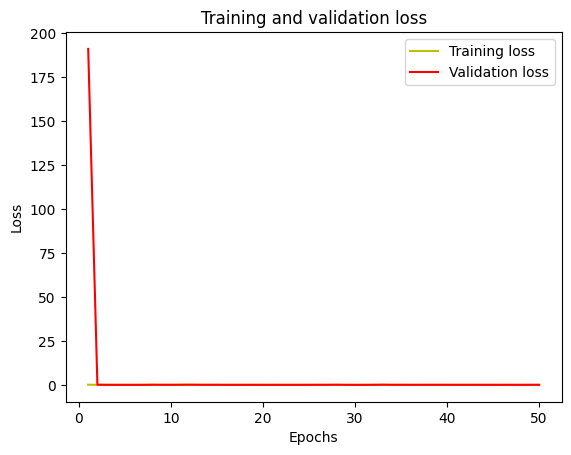

In [44]:
plot_loss_curves(unet_model_hist)

In [45]:
def plot_jacard_curves(history):
  loss = history.history['loss']
  epochs = range(1, len(loss) + 1)
  acc = history.history['jacard_coef']
  #acc = history.history['accuracy']
  val_acc = history.history['val_jacard_coef']
  #val_acc = history.history['val_accuracy']

  plt.plot(epochs, acc, 'y', label='Training Jacard')
  plt.plot(epochs, val_acc, 'r', label='Validation Jacard')
  plt.title('Training and validation Jacard')
  plt.xlabel('Epochs')
  plt.ylabel('Jacard')
  plt.legend()
  plt.show()

In [ ]:
plot_jacard_curves(unet_model_hist)

In [47]:
MODEL_PATH = '/content/cancer_instance_seg_unet_50_epochs.hdf5'

In [48]:
# Load the model for testing
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

In [66]:
TEST_IMG_IX = 2

In [67]:
test_img = X_test[TEST_IMG_IX]
ground_truth_mask = y_test[TEST_IMG_IX]

test_img_input=np.expand_dims(test_img, 0)
prediction_mask = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 29ms/step


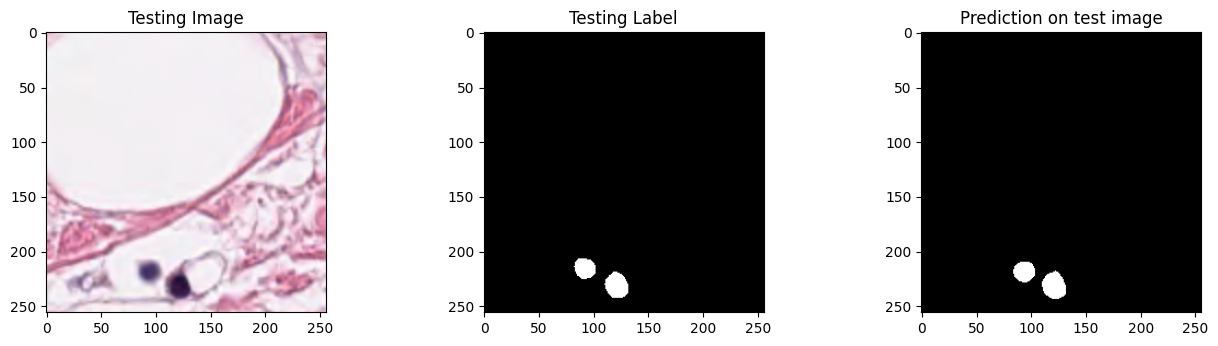

In [68]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_mask[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction_mask, cmap='gray')

plt.show()

### IoU (Intersection over Union) Calculation for single test image

In [69]:
from tensorflow.keras.metrics import MeanIoU

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth_mask[:,:,0], prediction_mask)

print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.89354986


### Calculate IoU for all test images and calculate Avg. IoU

In [80]:
import pandas as pd

def calculate_IoU_of_test_dataset(model, X_test, y_test, n_classes=2):
  IoU_values = []

  for ix, test_img in enumerate(X_test):
    ground_truth = y_test[ix]
    temp_img_input = np.expand_dims(test_img, 0)

    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)
    #print(IoU)

  df = pd.DataFrame(IoU_values, columns=["IoU"])
  #df = df[df.IoU != 1.0]
  mean_IoU = df.mean().values
  print("Mean IoU is: ", str(mean_IoU))

In [81]:
calculate_IoU_of_test_dataset(unet_model, X_test, y_test)

1/1 [==============================] - 0s 29ms/step
Mean IoU is:  [0.7219222]


### Reference

Original Paper: [Attention U-Net: Learning Where to Look for the Pancreas](https://arxiv.org/pdf/1804.03999.pdf)

[224 - Recurrent and Residual U-net](https://www.youtube.com/watch?v=7aDOtKN2cJs) by DigitalSreeni

[225 - Attention U-net. What is attention and why is it needed for U-Net? ](https://www.youtube.com/watch?v=KOF38xAvo8I) by DigitalSreeni

[226 - U-Net vs Attention U-Net vs Attention Residual U-Net - should you care? ](https://www.youtube.com/watch?v=L5iV5BHkMzM) by DigitalSreeni